# Explore half-hourly dataset

We will explore a half-hourly GPP dataset with ground measurements of GPP, climate variables (e.g. temperature, VPD, precipitation), as well as satellite observations (surface reflectance, vegetation indexes). The data were collected from flux tower sites across the world. These are the same sites as in the monthly dataset.

## Science background and questions
Plant physiology processes, such as photosynthesis, changes in response to concurrent environmental factors. Photosynthesis (GPP) has both diurnal and seasonal cycles, mostly triggered by change of solar radiation and temperature within the day and across seasons. For example, solar radiation and temperature normally increases from early morning, reaches the highest around noon or slightly after, and decreases in the afternoon through evening and night. Moreover, plants can also have memories of past experiences, usually due to recurrent environmental stress, which prepares them for future stressful conditions. This plant memory can both be short (i.e. within 24 hours) or long term (i.e. months or years). When this happens, plant photosynthesis can also be affected by past climate and environmental conditions. In this project, we want to model both GPP responses to both present and past environmental stimuli with sequential deep neural networks such as LSTM and Transformer. We will test whether considering sequential information can improve models’ predictive performance of GPP when benchmarked with regular models (e.g. random forest) with only concurrent inputs.

## Objectives
* Benchmark LSTM and other ML Models (Lasso, SVM, RF, XGBoost, MLP) for predicting hourly data
* Compare models for different sites of different PFTs

# Load Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

#modeling

from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import ensemble
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


The half-hourly data is saved as separate files per site. Each row in the data contains a GPP observation (“GPP_NT_VUT_REF”), atmospheric observations (half-hourly), and satellite observations (daily) for a half-hour time periods (TIMESTAMP_START, TIMESTAMP_END). 

**Target**: GPP_NT_VUT_REF  
**Features**: 
* Climate: 
  * “TA_ERA” (air temperature)
  * “P_ERA” (precipitation)
  * “VPD_ERA” (VPD)
  * “SW_IN_ERA” (solar radiation)
* Satellite
  * “b1”, “b2”, “b3”, “b4”, “b5”, “b6”, “b7”, “NDVI”, “EVI”, “NIRv”
* Categorical
  * “IGBP”
  * “Koppen”

The whole dataset exceeds 15 GB, which will not fit in memory of the colab hardware. So in this notebook, we will explore data for selected sites.

### Check the list of sites

In [3]:
site_path = '/global/scratch/users/yaqiantang/discoveryData/' + \
 'site_summary_v0_3_2.csv'
site_summary = pd.read_csv(site_path)
site_summary.head()

,SITE_ID,dataset,start_year,end_year,path,dup,IGBP,LOCATION_ELEV,LOCATION_LAT,LOCATION_LONG,SITE_NAME,koppen_sub,koppen_main,koppen_name,koppen_main_name,C3/C4,C4_percent
0,AR-SLu,FLUXNET,2009,2011,/Users/yanghuikang/Documents/Work/Research/Dat...,False,MF,NaN,-33.46480,-66.4598,San Luis,7,2,BSk,Arid,C3,67.08
1,AR-Vir,FLUXNET,2009,2012,/Users/yanghuikang/Documents/Work/Research/Dat...,False,ENF,NaN,-28.23950,-56.1886,Virasoro,14,3,Cfa,Temperate,C3,8.75
2,AT-Neu,FLUXNET,2002,2012,/Users/yanghuikang/Documents/Work/Research/Dat...,False,GRA,970.0,47.11667,11.3175,Neustift,26,4,Dfb,Cold,C3,0.00
3,AU-ASM,FLUXNET,2010,2014,/Users/yanghuikang/Documents/Work/Research/Dat...,False,SAV,NaN,-22.28300,133.2490,Alice Springs,4,2,BWh,Arid,C3,100.00
4,AU-Ade,FLUXNET,2007,2009,/Users/yanghuikang/Documents/Work/Research/Dat...,False,WSA,NaN,-13.07690,131.1178,Adelaide River,3,1,Aw,Tropical,C3,79.57


Print a list of site ID for each IGBP category:  
Check here for descriptions of the IGBP classification https://fluxnet.org/data/badm-data-templates/igbp-classification/  
Note that not all of the sites are in the half-hourly dataset.

In [4]:
with pd.option_context('display.max_colwidth', None):
    display(site_summary.groupby('IGBP')['SITE_ID'].apply(list))

IGBP
CRO                                                                                                                                                                                                                                                                                                                                    [DE-Seh, DK-Fou, FI-Jok, IT-CA2, US-Lin, US-Ne1, US-Ne2, US-Ne3, US-Tw3, US-Twt, US-ARM, US-Bi1, US-Bi2, US-CRT, US-Ro1, US-Ro5, US-Ro6, US-Tw2, US-Wgr, BE-Lon, CH-Oe2, CZ-KrP, DE-Geb, DE-Kli, DE-RuS, FI-Qvd, FR-Aur, FR-Gri, FR-Lam, IT-BCi, FR-EM2, SE-Lnn]
CSH                                                                                                                                                                                                                                                                                                                                                                                                                        

In [5]:
data_path = '/global/scratch/users/yaqiantang/discoveryData/'

In [6]:
def calculate_errors(y_train, y_train_predicted, y_test, y_test_predicted, model_name):
  r2_train = r2_score(y_train, y_train_predicted)
  r2_test = r2_score(y_test, y_test_predicted)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predicted))
  bias_train = np.mean(y_train - y_train_predicted)
  bias_test = np.mean(y_test - y_test_predicted)
  print("The TRAINING R2 score of " + model_name + " is: " + str(r2_train))
  print("The TESTING R2 score of " + model_name + " is: " + str(r2_test))
  print("The RMSE of predicting the TRAINING set of " + model_name + " is: " + str(rmse_train))
  print("The RMSE of predicting the TESTING set of " + model_name + " is: " + str(rmse_test))
  print("The bias of predicting the TRAINING set of " + model_name + " is: " + str(bias_train))
  print("The bias of predicting the TESTING set of " + model_name + " is: " + str(bias_test))
  return r2_test, rmse_test

def show_scatter_train(y_train, y_train_predicted, model_name):
  plt.figure(figsize=(8,5))
  plt.scatter(x = y_train, y = y_train_predicted)
  plt.plot(y_train, y_train, color = 'red', label = 'x=y')
  plt.title(model_name + " : observed vs. predicted for TRAIN set")
  plt.xlabel('y_train_Observed')
  plt.ylabel('y_train_Predicted');

def show_scatter_test(y_test, y_test_predicted, model_name):
  #plt.figure(figsize=(8,5))
  plt.scatter(x = y_test, y = y_test_predicted, s = 0.1)
  plt.plot(y_test, y_test, color = 'red', label = 'x=y')
  plt.title(model_name + " : observed vs. predicted for TEST set")
  plt.xlabel('y_test_Observed')
  plt.ylabel('y_test_Predicted');

# ML Models Development

# 5th site - GRA: US-Var

In [7]:
site_id = 'US-Var' # 
df = pd.read_csv(data_path + 'data_full_half_hourly_raw_v0_1_' + site_id + '.csv')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200011010000,200011010030,8.59,0,8.117,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
1,200011010030,200011010100,8.54,0,7.898,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2,200011010100,200011010130,8.51,0,7.680,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
3,200011010130,200011010200,8.07,0,7.353,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
4,200011010200,200011010230,7.43,0,7.027,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate


In [8]:
df = df[df['SW_IN_ERA'] != 0]
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
13,200011010630,200011010700,6.052,0,5.271,47.2345,0.0,0,16.640,276.486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
14,200011010700,200011010730,6.620,0,5.181,177.1940,83.6,0,111.486,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
15,200011010730,200011010800,8.420,0,6.729,302.1940,171.9,0,189.377,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
16,200011010800,200011010830,10.620,0,8.277,418.2980,239.3,0,261.711,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
17,200011010830,200011010900,13.130,0,9.826,523.5210,353.5,0,327.250,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate


In [9]:
target = 'GPP_NT_VUT_REF'
features = ['year','TA_ERA','SW_IN_ERA','P_ERA','VPD_ERA','b1','b2','b3','b4','b5','b6',
            'b7','NDVI','EVI','NIRv']
# and categorical features: IGBP and koppen

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
datetime,,,,,,,,,,,,,,,,,,,,,
2000-11-01 06:30:00,200011010630,200011010700,6.052,0,5.271,47.2345,0.0,0,16.640,276.486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 07:00:00,200011010700,200011010730,6.620,0,5.181,177.1940,83.6,0,111.486,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 07:30:00,200011010730,200011010800,8.420,0,6.729,302.1940,171.9,0,189.377,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 08:00:00,200011010800,200011010830,10.620,0,8.277,418.2980,239.3,0,261.711,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 08:30:00,200011010830,200011010900,13.130,0,9.826,523.5210,353.5,0,327.250,291.970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate


In [10]:
# One hot encoding categorical variables: IGBP and Koppen
df_ohe = df[[target, 'IGBP', 'koppen'] + features]

categorical_columns = ['IGBP', 'koppen']
for col in categorical_columns:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df_ohe = pd.concat((df_ohe, col_ohe), axis=1).drop(col, axis=1)

df_ohe.columns

Index(['GPP_NT_VUT_REF', 'year', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv',
       'IGBP_GRA', 'koppen_Temperate'],
      dtype='object')

In [11]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    return df

In [12]:
# clean the data.
df = clean_dataset(df_ohe)
df.head()

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2001-01-01 07:30:00,0.227214,2001,2.660,46.637,0.0,2.433,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 08:00:00,-0.225467,2001,3.753,115.554,0.0,2.719,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 08:30:00,13.603100,2001,4.846,179.053,0.0,3.006,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 09:00:00,13.754500,2001,5.939,236.048,0.0,3.292,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 09:30:00,18.128900,2001,7.032,285.566,0.0,3.578,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [13]:
# test train split grouped by year
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 42)
split = splitter.split(df, groups=df['year'])
train_inds, test_inds = next(split)

train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

In [14]:
train_df.head(2)

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2002-01-09 07:30:00,-0.775532,2002,6.737,40.453,0.0,2.000,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1
2002-01-09 08:00:00,-0.534859,2002,7.461,100.113,0.0,2.186,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1


In [15]:
test_df.head(2)

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2001-01-01 07:30:00,0.227214,2001,2.660,46.637,0.0,2.433,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 08:00:00,-0.225467,2001,3.753,115.554,0.0,2.719,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [16]:
train_df['year'].value_counts()

2007    8781
2009    8766
2011    8751
2008    8645
2003    8617
2002    8587
2004    8553
2014    8543
2005    7845
Name: year, dtype: int64

In [17]:
test_df['year'].value_counts()

2012    8788
2013    8782
2006    8700
2001    8549
2010    8146
Name: year, dtype: int64

In [18]:
X_train = train_df.drop([target, 'year'], axis = 1)
X_train.head(2)

,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,
2002-01-09 07:30:00,6.737,40.453,0.0,2.000,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1
2002-01-09 08:00:00,7.461,100.113,0.0,2.186,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1


In [19]:
y_train = train_df[target]
y_train.head(2)

datetime
2002-01-09 07:30:00   -0.775532
2002-01-09 08:00:00   -0.534859
Name: GPP_NT_VUT_REF, dtype: float64

In [20]:
X_test = test_df.drop([target, 'year'], axis = 1)
X_test.head(2)

,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,
2001-01-01 07:30:00,2.660,46.637,0.0,2.433,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 08:00:00,3.753,115.554,0.0,2.719,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [21]:
y_test = test_df[target]
y_test.head(2)

datetime
2001-01-01 07:30:00    0.227214
2001-01-01 08:00:00   -0.225467
Name: GPP_NT_VUT_REF, dtype: float64

In [22]:
print ("train_X.shape" , X_train.shape) 
print ("train_y.shape" , y_train.shape)
print ("test_X.shape" , X_test.shape) 
print ("test_y.shape" , y_test.shape)

train_X.shape (77088, 16)
train_y.shape (77088,)
test_X.shape (42965, 16)
test_y.shape (42965,)


In [23]:
# Function to standardize variables and create test/train split 
'''
def get_train_test_split(df, test_size, random_state, neural_net=False):
    """
    This function returns four dataframes containing the testing and training X and y values.
    Input:
        df: df that contains the target/response variable and all the features.
        y_col: a column name (as a string) of df that represents the response variable
        test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split
        random_state: an integer, used to define the random state,
        neural_net: boolean if making split for neural network model to determine how we should standardize 
    Output: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    X = df[['GPP_NT_VUT_REF', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA', 'b1', 'b2',
       'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv', 'IGBP_GRA',
       'koppen_Temperate']]
    y = df[target]
    
    # Standardize the data
    if not neural_net:
        scaler = StandardScaler()
        scaler.fit(X) 
        X_stnd = scaler.transform(X)
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_stnd = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=test_size, 
                                                        random_state=random_state, shuffle=True)
    
    return X_train, X_test, y_train, y_test, scaler
    
'''

'\ndef get_train_test_split(df, test_size, random_state, neural_net=False):\n    """\n    This function returns four dataframes containing the testing and training X and y values.\n    Input:\n        df: df that contains the target/response variable and all the features.\n        y_col: a column name (as a string) of df that represents the response variable\n        test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split\n        random_state: an integer, used to define the random state,\n        neural_net: boolean if making split for neural network model to determine how we should standardize \n    Output: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the \n    feature matrix X and response matrix y\n    """\n    \n    X = df[[\'GPP_NT_VUT_REF\', \'TA_ERA\', \'SW_IN_ERA\', \'P_ERA\', \'VPD_ERA\', \'b1\', \'b2\',\n       \'b3\', \'b4\', \'b5\', \'b6\', \'b7\', \'NDVI\', \'EVI\', \'NIRv\', \

In [24]:
#X_train, X_test, y_train, y_test, scaler = get_train_test_split(df, 0.3, 2022)

### Lasso

In [25]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2022)

lasso_model = LassoCV(cv = kf, alphas=np.linspace(0.001, 10, 100), max_iter = 10000)
lasso_model.fit(X_train, y_train)
print('Lasso Model Optimal Alpha: ', lasso_model.alpha_)

Lasso Model Optimal Alpha:  0.001


In [26]:
# Cross Validation Results

rmse = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(lasso_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 3.580, Standard Deviation : 0.031
R2: 0.690, Standard Deviation : 0.006


In [27]:
# Test Results

lasso_y_train_predicted = lasso_model.predict(X_train)
lasso_y_test_predicted = lasso_model.predict(X_test)
lasso_r2, lasso_rmse = calculate_errors(y_train, lasso_y_train_predicted, y_test, 
                                        lasso_y_test_predicted, "Lasso")

The TRAINING R2 score of Lasso is: 0.6905526666146755
The TESTING R2 score of Lasso is: 0.6207201132092224
The RMSE of predicting the TRAINING set of Lasso is: 3.5783216723877156
The RMSE of predicting the TESTING set of Lasso is: 3.8151924684703156
The bias of predicting the TRAINING set of Lasso is: 2.4304159994450917e-15
The bias of predicting the TESTING set of Lasso is: 0.2463200061085652


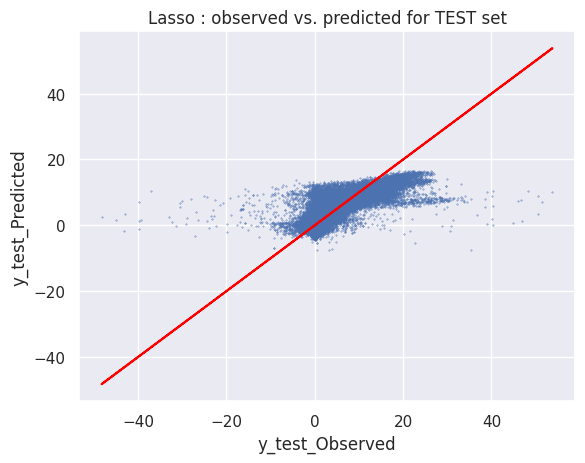

In [28]:
show_scatter_test(y_test, lasso_y_test_predicted, "Lasso")

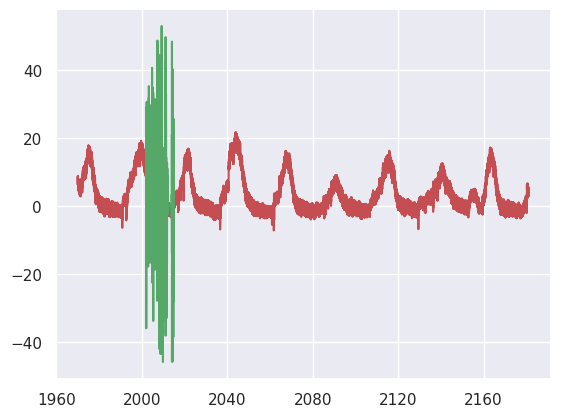

In [47]:
plt.plot(lasso_y_train_predicted, color='r')
plt.plot(y_train, color='g')

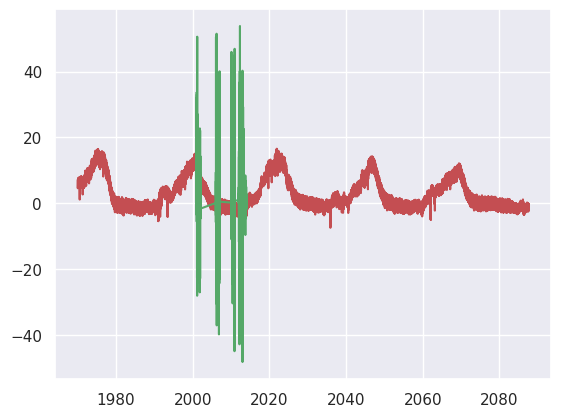

In [29]:
plt.plot(lasso_y_test_predicted, color='r')
plt.plot(y_test, color='g')

### SVM

In [86]:
# NOTE: TAKES A LONG TIME TO RUN

# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = svm_param_grid, 
                                scoring='neg_mean_squared_error', n_iter = 5, 
                                cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)
# Print best parameters after tuning
print('SVM Best Parameters: ', svm_random.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=27.0min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=27.3min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=27.4min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=27.4min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=27.6min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=47.2min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=47.2min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=47.6min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=47.9min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=49.5min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=53.0min
[CV] END ...........................C=1, gamma=1,

KeyboardInterrupt: 

In [88]:
# Model with Cross Validated Hyperparameters
svm_model = SVR(kernel = 'rbf', gamma = 0.001, C = 10, verbose = True)
svm_model.fit(X_train, y_train)

[LibSVM].....................................................................................................................................
*...............................................................................*.........*
optimization finished, #iter = 227578
obj = -2530903.577432, rho = 0.058200
nSV = 126092, nBSV = 125596


SVR(C=10, gamma=0.001, verbose=True)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(svm_model, X_train, y_train, 
                       scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(svm_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [82]:
# Test Results
svm_y_train_predicted = svm_model.predict(X_train)
svm_y_test_predicted = svm_model.predict(X_test)
svm_r2, svm_rmse = calculate_errors(y_train, svm_y_train_predicted, y_test, svm_y_test_predicted, "SVM")

NameError: name 'svm_model' is not defined

In [83]:
show_scatter_test(y_test, svm_y_test_predicted, "SVM")

NameError: name 'svm_y_test_predicted' is not defined

### Random Forest


In [152]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 800, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.1, 0.5, 1.0]
# Maximum number of levels in tree
max_depth = [3, 4, 5, 6]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, search across 10 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               scoring='neg_mean_squared_error',n_iter = 10, cv = kf, verbose=2, 
                               random_state=2022, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# Print best parameters after tuning
print('Random Forest Best Parameters: ')
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

Random Forest Best Parameters: 


{'n_estimators': 1000,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 0.5,
 'max_depth': 6,
 'bootstrap': True}

[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=  25.7s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=  25.6s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=  25.7s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=  25.7s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=  25.8s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=  25.9s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=  25.8s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, m

In [30]:
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_split=6, min_samples_leaf=6, 
                                 max_features=0.5, max_depth = 6, bootstrap = True)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.5, min_samples_leaf=6,
                      min_samples_split=6, n_estimators=1000)

In [154]:
# Cross Validation Results

rmse = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 2.488, Standard Deviation : 0.018
R2: 0.850, Standard Deviation : 0.004


In [31]:
# Train/Test Results

rf_y_train_predicted = rf_model.predict(X_train)
rf_y_test_predicted = rf_model.predict(X_test)
rf_r2, rf_rmse = calculate_errors(y_train, rf_y_train_predicted, 
                                  y_test, rf_y_test_predicted, "Random Forest")

The TRAINING R2 score of Random Forest is: 0.8549623966798188
The TESTING R2 score of Random Forest is: 0.7628556173276433
The RMSE of predicting the TRAINING set of Random Forest is: 2.449775651323872
The RMSE of predicting the TESTING set of Random Forest is: 3.0167753212086206
The bias of predicting the TRAINING set of Random Forest is: 0.0004961779477947506
The bias of predicting the TESTING set of Random Forest is: 0.19935882098998317


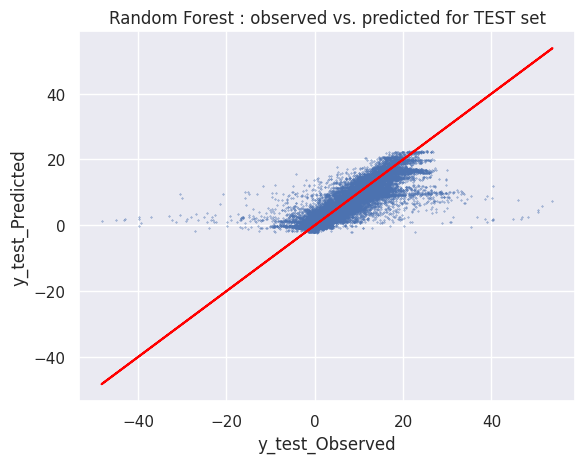

In [32]:
show_scatter_test(y_test, rf_y_test_predicted, "Random Forest")

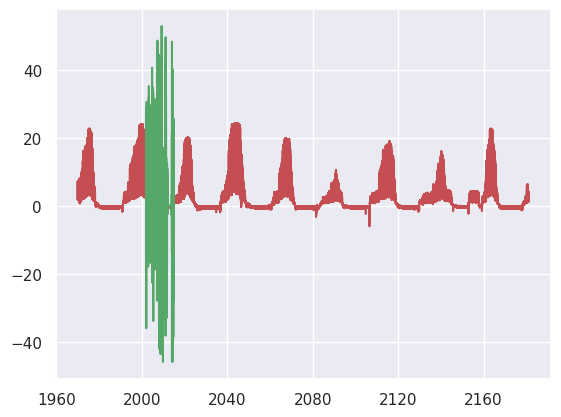

In [45]:
plt.plot(rf_y_train_predicted, color='r')
plt.plot(y_train, color='g')

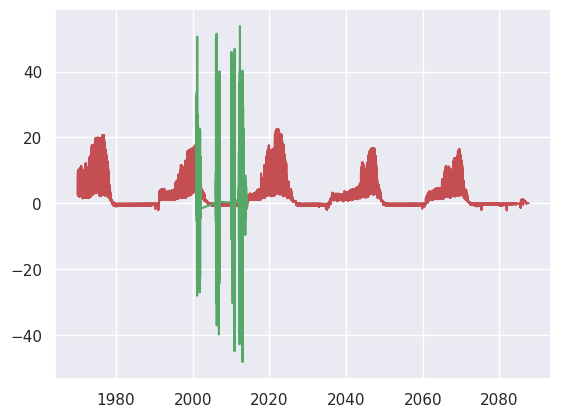

In [33]:
plt.plot(rf_y_test_predicted, color='r')
plt.plot(y_test, color='g')

## XGBoost

In [159]:
xgb_param_grid = {'max_depth': [3, 5, 6, 10], 
                  'min_child_weight': [1, 3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 300, 500, 800, 1000]}

xgbr = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgbr, param_distributions=xgb_param_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print("XGBoost Best Parameters: ")
xgb_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost Best Parameters: 


{'subsample': 0.8999999999999999,
 'n_estimators': 800,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7999999999999999}

[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=100, subsample=0.6; total time=  13.6s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=100, subsample=0.6; total time=  13.6s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=100, subsample=0.6; total time=  13.5s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=800, subsample=0.6; total time=  13.6s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=100, subsample=0.6; total time=  13.7s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, le

[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=0.8999999999999999; total time= 1.3min
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=0.8999999999999999; total time= 1.3min
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=0.8999999999999999; total time= 1.3min
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=0.8999999999999999; total time= 1.4min


In [34]:
xgb_model = XGBRegressor(subsample = 0.9, n_estimators = 800, max_depth = 10, min_child_weight = 5,
                         learning_rate = 0.01, colsample_bytree = 0.9, colsample_bylevel = 0.8)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [161]:
# Cross Validation Results

rmse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

KeyboardInterrupt: 

In [35]:
#Train/Test Results

xgb_y_train_predicted = xgb_model.predict(X_train)
xgb_y_test_predicted = xgb_model.predict(X_test)
xgb_r2, xgb_rmse = calculate_errors(y_train, xgb_y_train_predicted, y_test, xgb_y_test_predicted, "XGBoost")

The TRAINING R2 score of XGBoost is: 0.953563605283808
The TESTING R2 score of XGBoost is: 0.7527906195666383
The RMSE of predicting the TRAINING set of XGBoost is: 1.3861660361350148
The RMSE of predicting the TESTING set of XGBoost is: 3.080129802173771
The bias of predicting the TRAINING set of XGBoost is: 0.0010390172431844005
The bias of predicting the TESTING set of XGBoost is: 0.36135873527526674


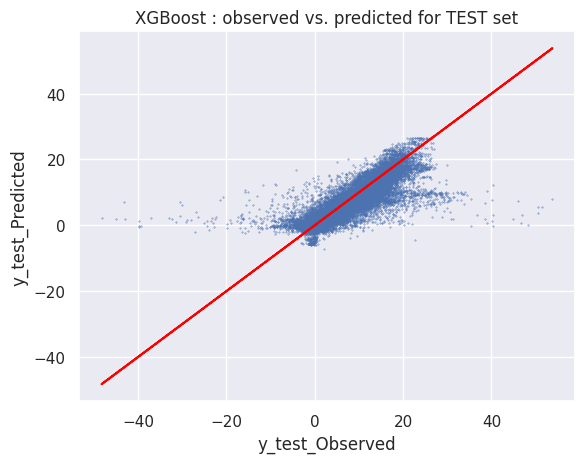

In [36]:
show_scatter_test(y_test, xgb_y_test_predicted, "XGBoost")

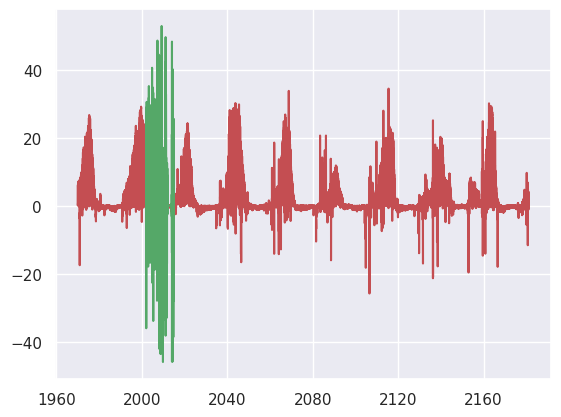

In [43]:
plt.plot(xgb_y_train_predicted, color='r')
plt.plot(y_train, color='g')

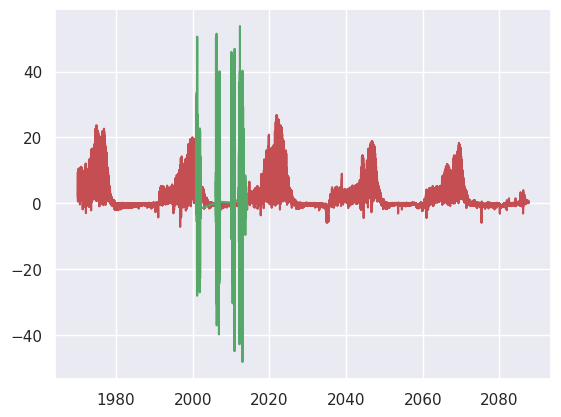

In [37]:
plt.plot(xgb_y_test_predicted, color='r')
plt.plot(y_test, color='g')

## MLP

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [165]:
#mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test, mlp_scaler = get_train_test_split(df, 0.3, 2022, True)

In [166]:
#sc = StandardScaler()

#scaler = sc.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_train_scaled = scaler.transform(X_test)

In [ ]:
# https://stackoverflow.com/questions/61163759/tuning-mlpregressor-hyper-parameters
# https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/

# doing hyperparameter tuning to find the best parameters for MLP
estimator = MLPRegressor(max_iter = 5000)
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
          #'learning_rate_init': [0.005, 0.008, 0.01],
          #'batch_size': [3000, 4000, 5000]
             }

gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

print("MLP Best Parameters: ")
grid_result.best_params_

In [39]:
mlp_model = MLPRegressor(activation = 'logistic',
                        alpha = 0.05,
                        hidden_layer_sizes = (50, 50, 50),
                        learning_rate = 'adaptive',
                        solver = 'adam').fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='neg_root_mean_squared_error')
r2 = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='r2')

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

In [40]:
# Train/Test Results

mlp_y_train_predicted = mlp_model.predict(X_train)
mlp_y_test_predicted = mlp_model.predict(X_test)
mlp_r2, mlp_rmse = calculate_errors(y_train, mlp_y_train_predicted, y_test, mlp_y_test_predicted, "MLP")

The TRAINING R2 score of MLP is: 0.8216439161510896
The TESTING R2 score of MLP is: 0.728349576276806
The RMSE of predicting the TRAINING set of MLP is: 2.716626735784283
The RMSE of predicting the TESTING set of MLP is: 3.2288044205131783
The bias of predicting the TRAINING set of MLP is: 0.4675908208266737
The bias of predicting the TESTING set of MLP is: 0.6629751668918623


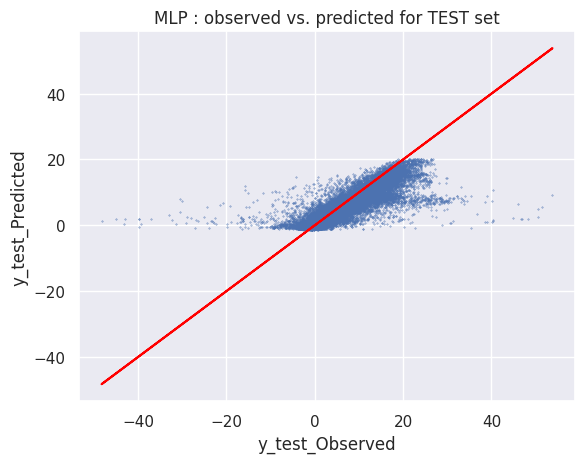

In [41]:
show_scatter_test(y_test, mlp_y_test_predicted, "MLP")

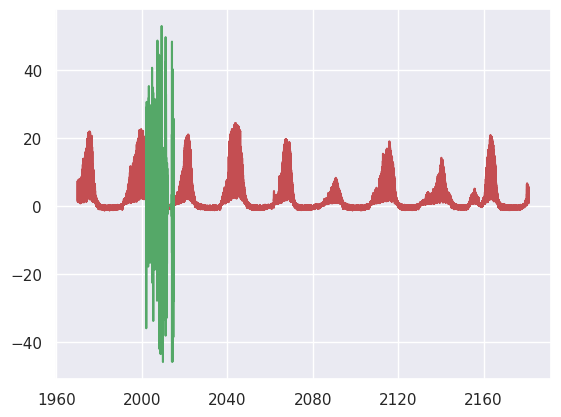

In [44]:
plt.plot(mlp_y_train_predicted, color='r')
plt.plot(y_train, color='g')

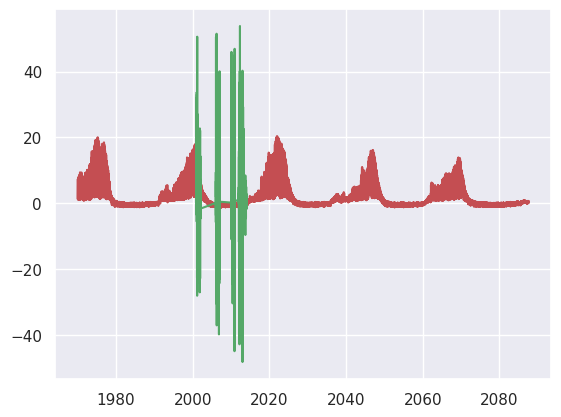

In [42]:
plt.plot(mlp_y_test_predicted, color='r')
plt.plot(y_test, color='g')

## Model Comparison

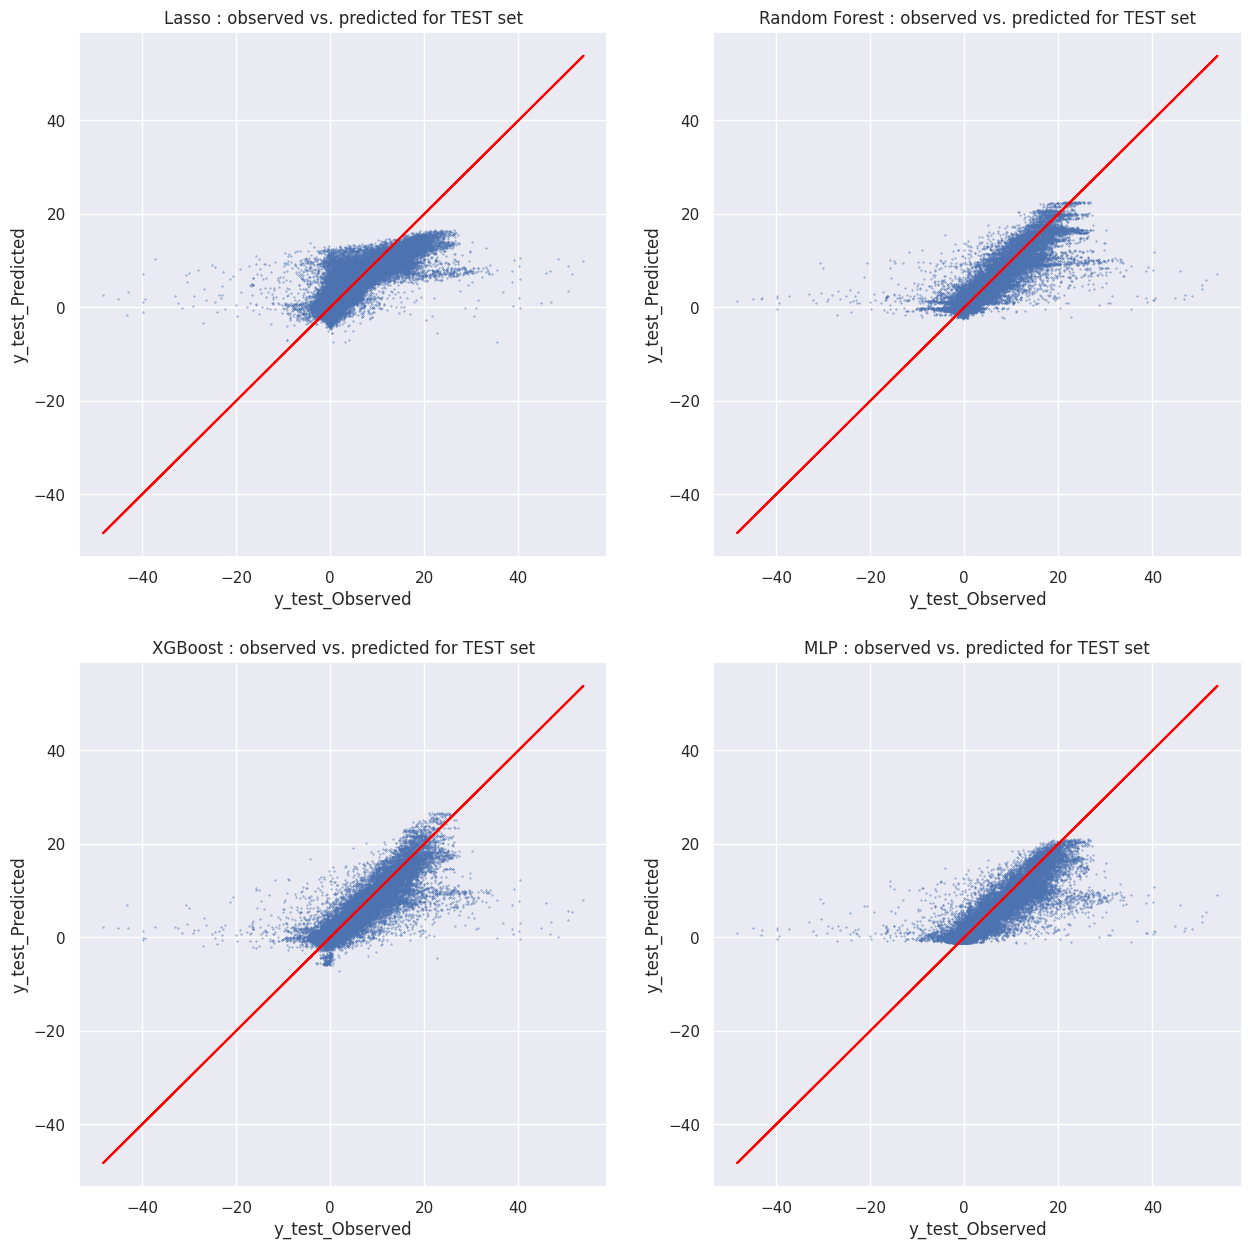

In [170]:
# Predicted Values

models = ["Lasso", "Random Forest", "XGBoost", "MLP"]
test_values = [y_test, y_test, y_test, y_test]
predictions = [lasso_y_test_predicted, rf_y_test_predicted, xgb_y_test_predicted, mlp_y_test_predicted]


fig=plt.figure(figsize=[15,15])

count = 0
for i in range(len(models)):
  count += 1
  plt.subplot(2,2,count)
  show_scatter_test(test_values[i], predictions[i], models[i])

Text(0.5, 1.0, 'Testing R2 Scores Across Models')

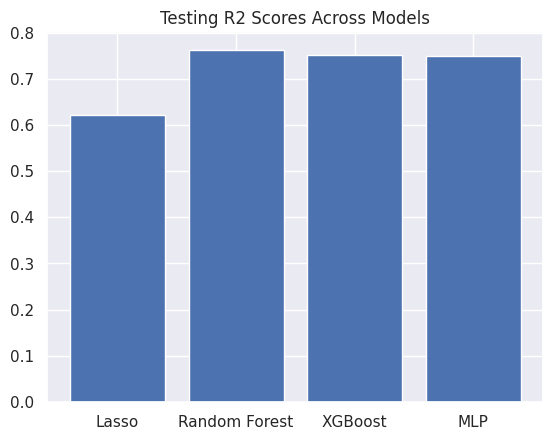

In [171]:
# Test R2 Score Comparison
r2_scores = [lasso_r2, rf_r2, xgb_r2, mlp_r2]

plt.bar(models, r2_scores)
plt.title("Testing R2 Scores Across Models")

Text(0.5, 1.0, 'Testing RMSE Scores Across Models')

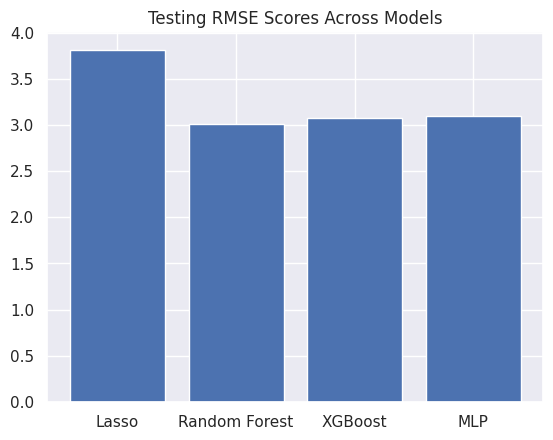

In [172]:
# RMSE Comparison
rmse_scores = [lasso_rmse, rf_rmse, xgb_rmse, mlp_rmse]

plt.bar(models, rmse_scores)
plt.title("Testing RMSE Scores Across Models")

# 6th Site - ES-LJu

In [100]:
site_id = 'ES-LJu' # 
df = pd.read_csv(data_path + 'data_full_half_hourly_raw_v0_1_' + site_id + '.csv')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200405260000,200405260030,7.856,0,8.325,0.0,0.0,0,0.0,314.215,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
1,200405260030,200405260100,7.650,0,8.180,0.0,0.0,0,0.0,314.215,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
2,200405260100,200405260130,7.672,0,8.035,0.0,0.0,0,0.0,328.276,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
3,200405260130,200405260200,7.793,0,8.300,0.0,0.0,0,0.0,328.276,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
4,200405260200,200405260230,7.638,0,8.565,0.0,0.0,0,0.0,339.403,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate


In [101]:
df = df[df['SW_IN_ERA'] != 0]
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
12,200405260600,200405260630,7.844,0,8.142,59.7503,6.820,0,18.951,325.472,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
13,200405260630,200405260700,7.244,0,8.113,188.3740,14.776,0,58.214,325.472,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
14,200405260700,200405260730,7.467,0,8.085,318.7920,46.602,0,133.853,321.628,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
15,200405260730,200405260800,7.873,0,8.474,448.7260,163.095,0,187.961,321.628,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
16,200405260800,200405260830,8.878,0,8.863,575.9530,211.375,0,212.237,333.820,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate


In [102]:
target = 'GPP_NT_VUT_REF'
features = ['year','TA_ERA','SW_IN_ERA','P_ERA','VPD_ERA','b1','b2','b3','b4','b5','b6','b7','NDVI','EVI','NIRv']
# and categorical features: IGBP and koppen

df['datetime'] = pd.to_datetime(df['TIMESTAMP_START'])
df = df.set_index('datetime')

In [103]:
# One hot encoding categorical variables: IGBP and Koppen
df_ohe = df[[target, 'IGBP', 'koppen'] + features]

categorical_columns = ['IGBP', 'koppen']
for col in categorical_columns:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df_ohe = pd.concat((df_ohe, col_ohe), axis=1).drop(col, axis=1)

df_ohe.columns

Index(['GPP_NT_VUT_REF', 'year', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv',
       'IGBP_OSH', 'koppen_Temperate'],
      dtype='object')

In [104]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    return df

In [105]:
# clean the data.
df = clean_dataset(df_ohe)

In [106]:
df.head()

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_OSH,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
1970-01-01 00:03:20.501010830,0.173490,2005,0.547,24.994,0.0,3.138,0.08,0.1381,0.038,0.0634,0.181,0.1913,0.1283,0.266392,0.108957,0.036789,1,1
1970-01-01 00:03:20.501010900,0.299267,2005,1.227,96.233,0.0,3.420,0.08,0.1381,0.038,0.0634,0.181,0.1913,0.1283,0.266392,0.108957,0.036789,1,1
1970-01-01 00:03:20.501010930,0.322733,2005,2.037,152.955,0.0,3.774,0.08,0.1381,0.038,0.0634,0.181,0.1913,0.1283,0.266392,0.108957,0.036789,1,1
1970-01-01 00:03:20.501011000,0.702521,2005,2.847,238.424,0.0,4.127,0.08,0.1381,0.038,0.0634,0.181,0.1913,0.1283,0.266392,0.108957,0.036789,1,1
1970-01-01 00:03:20.501011030,0.024992,2005,5.514,290.851,0.0,6.202,0.08,0.1381,0.038,0.0634,0.181,0.1913,0.1283,0.266392,0.108957,0.036789,1,1


In [107]:
# test train split grouped by SiteID, year, month
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 42)
split = splitter.split(df, groups=df['year'])
train_inds, test_inds = next(split)

train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

In [108]:
X_train = train_df.drop([target, 'year'], axis = 1)
X_train.head(2)

y_train = train_df[target]
y_train.head(2)

X_test = test_df.drop([target, 'year'], axis = 1)
X_test.head(2)

y_test = test_df[target]
y_test.head(2)

datetime
1970-01-01 00:03:20.501010830    0.173490
1970-01-01 00:03:20.501010900    0.299267
Name: GPP_NT_VUT_REF, dtype: float64

## Lasso

In [109]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2022)

lasso_model = LassoCV(cv = kf, alphas=np.linspace(0.001, 10, 100), max_iter = 10000)
lasso_model.fit(X_train, y_train)
print('Lasso Model Optimal Alpha: ', lasso_model.alpha_)

Lasso Model Optimal Alpha:  0.001


In [110]:
# Cross Validation Results

rmse = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(lasso_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 1.295, Standard Deviation : 0.011
R2: 0.299, Standard Deviation : 0.006


In [111]:
# Test Results

lasso_y_train_predicted = lasso_model.predict(X_train)
lasso_y_test_predicted = lasso_model.predict(X_test)
lasso_r2, lasso_rmse = calculate_errors(y_train, lasso_y_train_predicted, y_test, lasso_y_test_predicted, "Lasso")

The TRAINING R2 score of Lasso is: 0.29878243121429926
The TESTING R2 score of Lasso is: 0.2628900120345211
The RMSE of predicting the TRAINING set of Lasso is: 1.2945623307675183
The RMSE of predicting the TESTING set of Lasso is: 1.1161964402835085
The bias of predicting the TRAINING set of Lasso is: -1.5600990377148572e-16
The bias of predicting the TESTING set of Lasso is: -0.01815290940579239


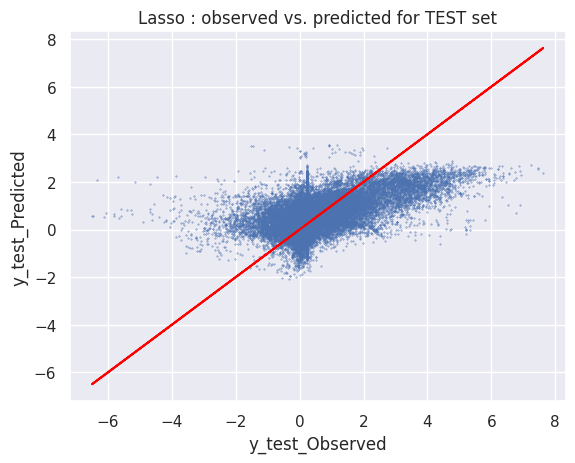

In [112]:
show_scatter_test(y_test, lasso_y_test_predicted, "Lasso")

## SVM

In [ ]:
# NOTE: TAKES A LONG TIME TO RUN

# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = svm_param_grid, 
                                scoring='neg_mean_squared_error', n_iter = 5, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)
# Print best parameters after tuning
print('SVM Best Parameters: ', svm_random.best_params_)

In [ ]:
# Model with Cross Validated Hyperparameters
svm_model = SVR(kernel = 'rbf', gamma = 0.1, C = 10)
svm_model.fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(svm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(svm_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [ ]:
# Test Results
svm_y_train_predicted = svm_model.predict(X_train)
svm_y_test_predicted = svm_model.predict(X_test)
calculate_errors(y_train, svm_y_train_predicted, y_test, svm_y_test_predicted, "SVM")

In [ ]:
show_scatter_test(y_test, svm_y_test_predicted, "SVM")

## Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [25, 50, 75, 100, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.1, 0.5, 1.0]
# Maximum number of levels in tree
max_depth = [3, 4, 5, 6]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, search across 10 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               scoring='neg_mean_squared_error',n_iter = 10, cv = kf, verbose=2, 
                               random_state=2022, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# Print best parameters after tuning
print('Random Forest Best Parameters: ')
rf_random.best_params_

In [113]:
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=6, 
                                 max_features=0.5, max_depth = 6, bootstrap = True)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.5, min_samples_leaf=6,
                      min_samples_split=6, n_estimators=200)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

In [114]:
# Train/Test Results

rf_y_train_predicted = rf_model.predict(X_train)
rf_y_test_predicted = rf_model.predict(X_test)
rf_r2, rf_rmse = calculate_errors(y_train, rf_y_train_predicted, y_test, rf_y_test_predicted, 'RF')

The TRAINING R2 score of RF is: 0.558838526519915
The TESTING R2 score of RF is: 0.34215703476005155
The RMSE of predicting the TRAINING set of RF is: 1.026822462720155
The RMSE of predicting the TESTING set of RF is: 1.0544733364183372
The bias of predicting the TRAINING set of RF is: 3.452805439884802e-05
The bias of predicting the TESTING set of RF is: -0.0008435954323392337


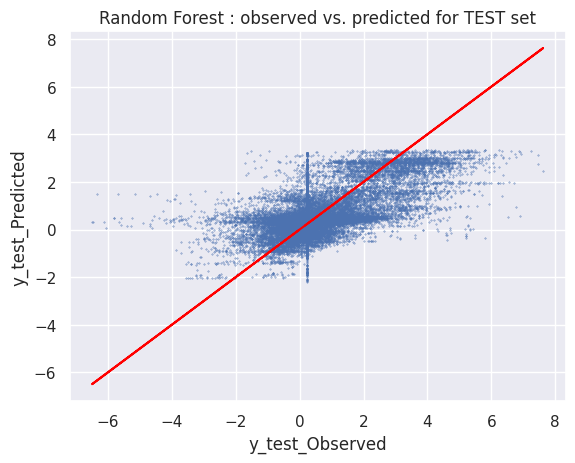

In [115]:
show_scatter_test(y_test, rf_y_test_predicted, "Random Forest")

## XGBoost

In [ ]:
xgb_param_grid = { 'max_depth': [3, 5, 6, 10], 
                  'min_child_weight': [1, 3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [50, 100, 150, 200, 250]}

xgbr = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgbr, param_distributions=xgb_param_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print("XGBoost Best Parameters: ")
xgb_random.best_params_

In [116]:
xgb_model = XGBRegressor(subsample = 0.9, n_estimators = 100, max_depth = 10, min_child_weight = 7,
                         learning_rate = 0.3, colsample_bytree = 0.7, colsample_bylevel = 0.4)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [117]:
#Train/Test Results

xgb_y_train_predicted = xgb_model.predict(X_train)
xgb_y_test_predicted = xgb_model.predict(X_test)
xgb_r2, xgb_rmse = calculate_errors(y_train, xgb_y_train_predicted, y_test, xgb_y_test_predicted, "XGBoost")

The TRAINING R2 score of XGBoost is: 0.8920225750991062
The TESTING R2 score of XGBoost is: 0.2320822336154016
The RMSE of predicting the TRAINING set of XGBoost is: 0.5079992304710059
The RMSE of predicting the TESTING set of XGBoost is: 1.1392835924613058
The bias of predicting the TRAINING set of XGBoost is: -0.0005273994180598497
The bias of predicting the TESTING set of XGBoost is: 0.026553330251420804


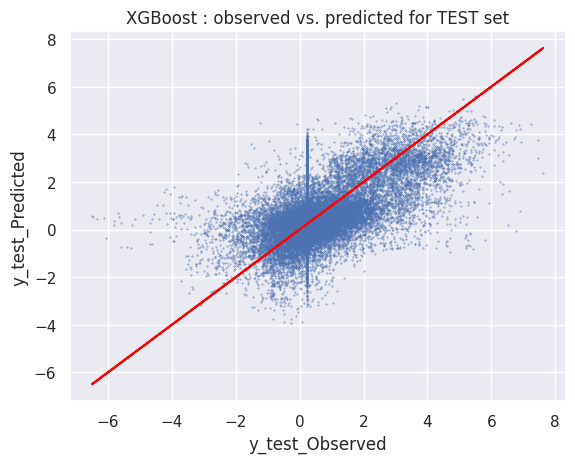

In [118]:
show_scatter_test(y_test, xgb_y_test_predicted, "XGBoost")

## MLP

In [119]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [60]:
#mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test, mlp_scaler = get_train_test_split(df, 0.3, 2022, True)

In [61]:
# https://stackoverflow.com/questions/61163759/tuning-mlpregressor-hyper-parameters
# https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/

# doing hyperparameter tuning to find the best parameters for MLP
estimator = MLPRegressor(max_iter = 5000)
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
          #'learning_rate_init': [0.005, 0.008, 0.01],
          #'batch_size': [3000, 4000, 5000]
             }

gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

print("MLP Best Parameters: ")
grid_result.best_params_

MLP Best Parameters: 


{'activation': 'logistic',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [120]:
mlp_model = MLPRegressor(activation = 'logistic',
                        alpha = 0.0001,
                        hidden_layer_sizes = (50, 100, 50),
                        learning_rate = 'constant',
                        solver = 'adam').fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='neg_root_mean_squared_error')
r2 = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='r2')

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

In [121]:
# Train/Test Results

mlp_y_train_predicted = mlp_model.predict(X_train)
mlp_y_test_predicted = mlp_model.predict(X_test)
mlp_r2, mlp_rmse = calculate_errors(y_train, mlp_y_train_predicted, y_test, mlp_y_test_predicted, "MLP")

The TRAINING R2 score of MLP is: 0.4751851712102001
The TESTING R2 score of MLP is: 0.342869615273781
The RMSE of predicting the TRAINING set of MLP is: 1.1199525430574313
The RMSE of predicting the TESTING set of MLP is: 1.0539020749003505
The bias of predicting the TRAINING set of MLP is: 0.11698043154094716
The bias of predicting the TESTING set of MLP is: 0.09915279738492623


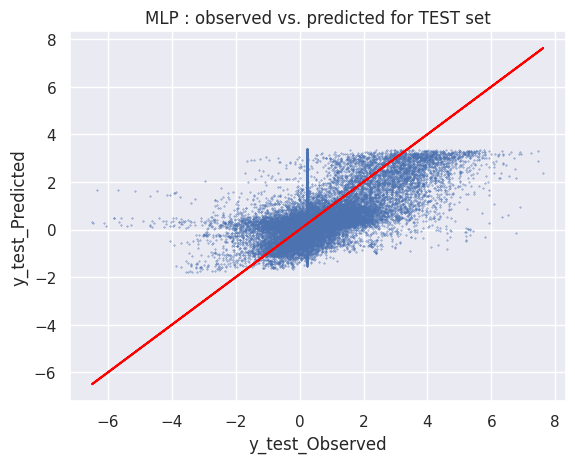

In [122]:
show_scatter_test(y_test, mlp_y_test_predicted, "MLP")

# Model Comparison

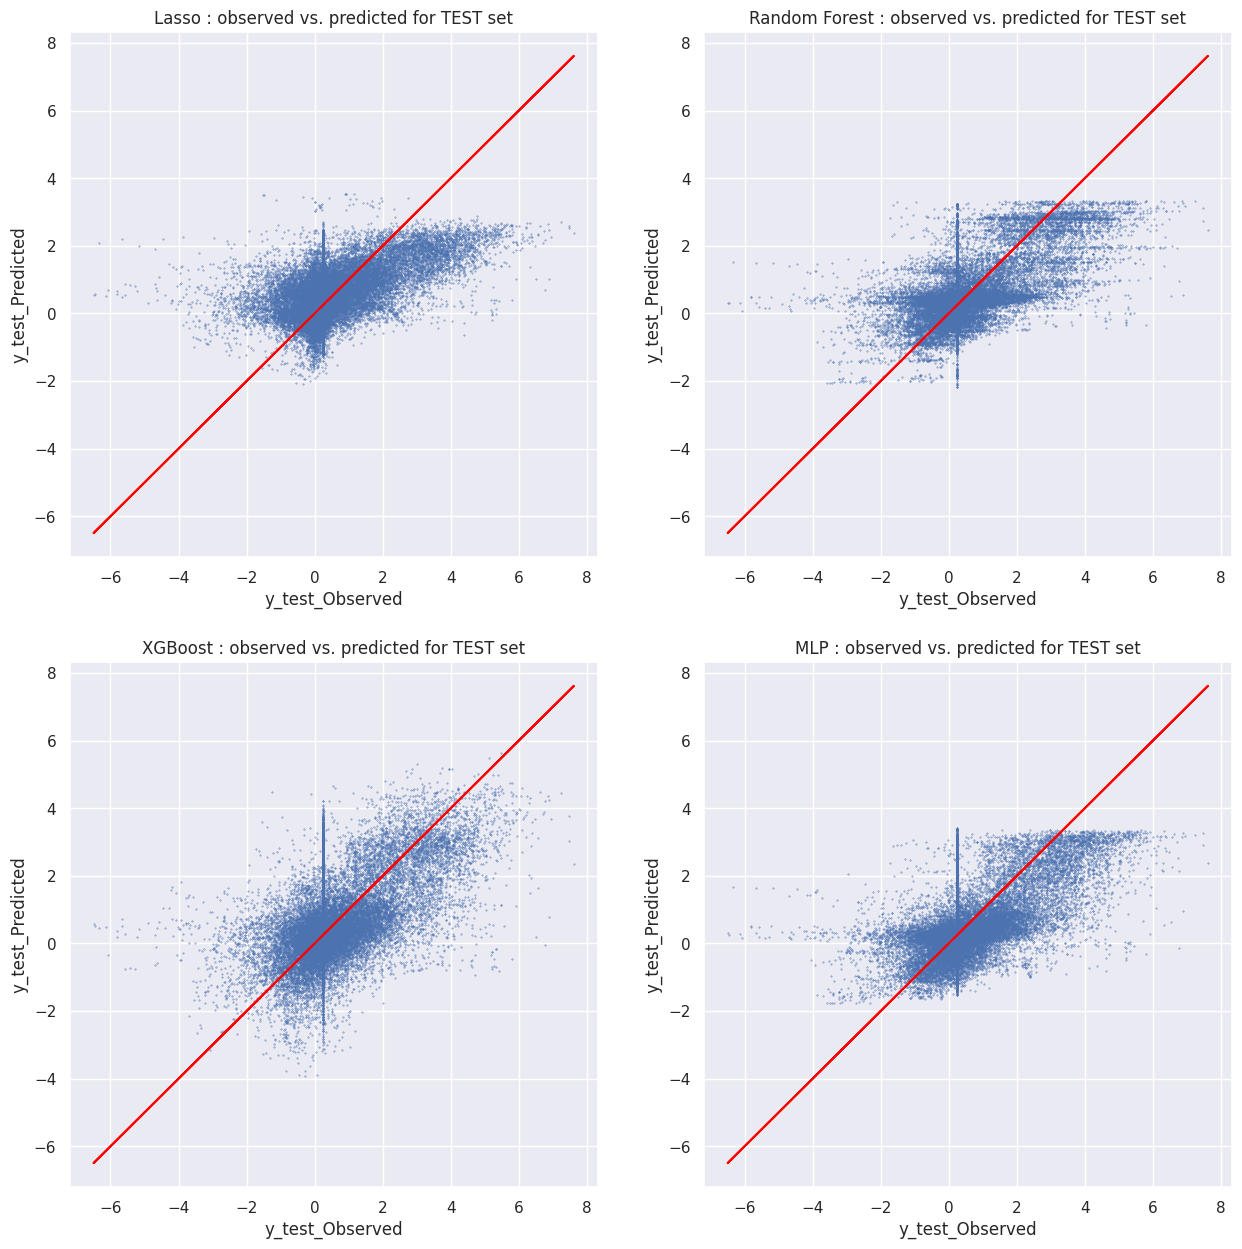

In [123]:
# Predicted Values

models = ["Lasso", "Random Forest", "XGBoost", "MLP"]
test_values = [y_test, y_test, y_test, y_test]
predictions = [lasso_y_test_predicted, rf_y_test_predicted, xgb_y_test_predicted, mlp_y_test_predicted]


fig=plt.figure(figsize=[15,15])

count = 0
for i in range(len(models)):
  count += 1
  plt.subplot(2,2,count)
  show_scatter_test(test_values[i], predictions[i], models[i])

In [125]:
lasso_r2

array([0.29318739, 0.29308361, 0.29670211, 0.30177276, 0.30799398])

In [126]:
rf_r2

array([0.29318739, 0.29308361, 0.29670211, 0.30177276, 0.30799398])

In [127]:
xgb_r2

array([0.29318739, 0.29308361, 0.29670211, 0.30177276, 0.30799398])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 5).

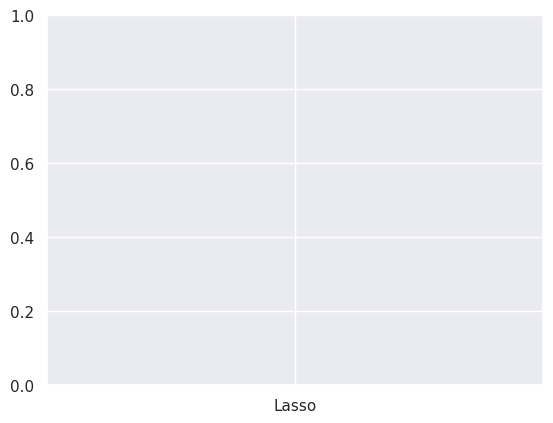

In [124]:
# Test R2 Score Comparison
r2_scores = [lasso_r2, rf_r2, xgb_r2, mlp_r2]

plt.bar(models, r2_scores)
plt.title("Testing R2 Scores Across Models")

In [ ]:
# RMSE Comparison
rmse_scores = [lasso_rmse, rf_rmse, xgb_rmse, mlp_rmse]

plt.bar(models, rmse_scores)
plt.title("Testing RMSE Scores Across Models")